# KAIST Summer Session 2018

## Neural Machine Translation using Sequence-to-Sequence with Attention (08.23.2018)
- This code is adapted from https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html.
- This dataset is obtained from http://www.manythings.org/anki/.

#### (Exercise) Try machine translation for other languages 
- Note that the performance may be poor because the number of sentence pairs is too small.

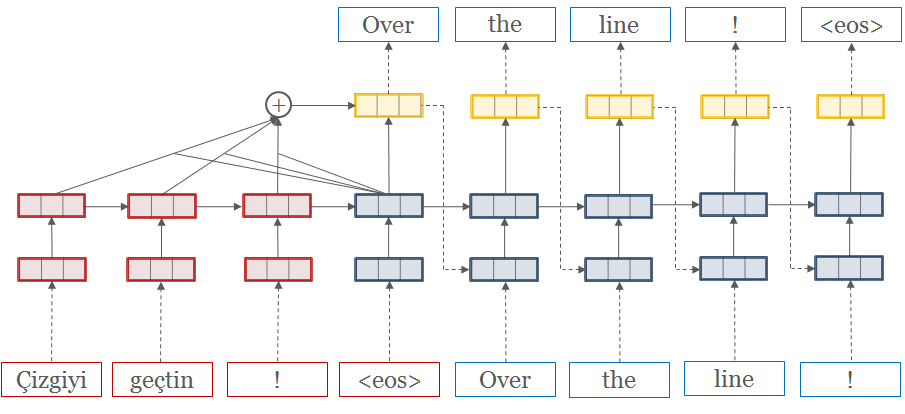

### 0. Data Preparation

In [11]:
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MAX_LENGTH = 10
hidden_size = 300
learning_rate = 0.01
dropout_p = 0.1
n_layers = 1
n_epochs = 100

In [12]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [13]:
def normalizeString(s):
    s = re.sub('[.,/?!-]', '', s)
    return s.lower()


def lengthfilter(pairs):
    return [pair for pair in pairs if len(pair[0].split(' ')) < MAX_LENGTH and len(pair[1].split(' ')) < MAX_LENGTH]

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('translation\%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')    
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs


def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    pairs = lengthfilter(pairs)
    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs:
        print(pair)
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [14]:
input_lang, output_lang, pairs = prepareData('english', 'korean', reverse=False)

random.shuffle(pairs)
training = pairs[: int(len(pairs) * 0.9)]
test = pairs[int(len(pairs) * 0.9):]

training_pairs = [tensorsFromPair(training[i]) for i in range(len(training))]

Reading lines...
Read 736 sentence pairs
['who', '누구']
['hello', '안녕']
['no way', '절대 아니야']
['no way', '그럴리가']
["i'm sad", '슬퍼']
['me too', '나도']
['perfect', '완벽해']
['shut up', '시끄러워']
['welcome', '어서오세요']
['welcome', '환영합니다']
['cheer up', '힘내']
['get lost', '꺼져']
["i'm ugly", '나는 못 생겼다']
['it hurts', '아파']
["let's go", '가자']
["don't lie", '거짓말 하지 마']
["don't lie", '거짓말 하지 마세요']
["i'm sorry", '미안해']
["i'm sorry", '미안해요']
["i'm sorry", '죄송합니다']
["i'm sorry", '유감입니다']
['of course', '물론이죠']
['seriously', '진심이야']
['take care', '주의하세요']
['be careful', '조심해']
['he is nice', '걔 괜찮아']
['hold still', '가만히 있으세요']
['hold still', '가만히 있어']
['how lovely', '어찌나 사랑스러운지']
['i felt bad', '난 기분이 나빴다']
['is that ok', '괜찮은 거예요']
['love hurts', '사랑은 아프다']
['boys do cry', '남자애도 운다']
["i don't lie", '나는 거짓말 하지 않습니다']
["i don't lie", '난 거짓말 안해']
["i don't lie", '나는 거짓말 하지 않아']
["i'm nervous", '긴장돼요']
["i'm nervous", '떨려요']
["i'm shocked", '충격이야']
["it's a pity", '안타까워요']
["what's that", '저건 뭐야']
["you're mine

### 1. Define a Neural Network

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)

    def forward(self, input, hidden, cell):
        embedded = self.embedding(input).view(1, 1, -1)
        output,(hidden, cell) = self.lstm(embedded,(hidden, cell))
        return output, hidden, cell

    def init_hidden_cell(self):
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size, device=device)
        cell = torch.zeros(self.n_layers, 1, self.hidden_size, device=device)
        return hidden,cell

In [16]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size,n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, n_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, cell, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        
        output,(hidden, cell) = self.lstm(output,(hidden, cell))
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, cell, attn_weights

    def init_hidden_cell(self):
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size, device=device)
        cell = torch.zeros(self.n_layers, 1, self.hidden_size, device=device)
        return hidden, cell

### 2. Define a Loss Function and Optimizer

In [17]:
# Instantiate the seq2seq model
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words,n_layers, dropout_p=dropout_p).to(device)

# Set loss and optimizer function
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(attn_decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

### 3. Training

In [18]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder.train()
    decoder.train()    
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    
    loss = 0

    # Encoding
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size,  device=device)
    encoder_hidden, encoder_cell = encoder.init_hidden_cell()
    
    for ei in range(input_length):
        encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
        encoder_outputs[ei] = encoder_output[0, 0]

        
    # Decoding using the encoded representation          
    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [19]:
import time
import math

def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [20]:
print_loss_total = 0
start = time.time()

for epoch in range(1, n_epochs+1):    
    for i in range(len(training_pairs)):
        training_pair = random.choice(training_pairs)
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, attn_decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        
    print_loss_average = print_loss_total / len(training_pairs)    
    print('Epoch {}'.format(epoch),' {} ({:.0f}%) {:.4f}'.format(time_since(start, epoch / n_epochs), epoch / n_epochs * 100, print_loss_average))
    print_loss_total = 0
    
print("Learning finished!")

Epoch 1  0m 36s (- 59m 43s) (1%) 4.4605
Epoch 2  1m 15s (- 61m 29s) (2%) 4.3920
Epoch 3  1m 53s (- 61m 18s) (3%) 4.4229
Epoch 4  2m 36s (- 62m 40s) (4%) 4.5525
Epoch 5  3m 19s (- 63m 4s) (5%) 4.3227
Epoch 6  4m 2s (- 63m 24s) (6%) 4.3938
Epoch 7  4m 47s (- 63m 43s) (7%) 4.1989
Epoch 8  5m 35s (- 64m 17s) (8%) 4.0788
Epoch 9  6m 27s (- 65m 18s) (9%) 3.7997
Epoch 10  7m 22s (- 66m 21s) (10%) 3.4409
Epoch 11  8m 17s (- 67m 9s) (11%) 3.2113
Epoch 12  9m 4s (- 66m 30s) (12%) 2.7702
Epoch 13  9m 53s (- 66m 12s) (13%) 2.2950
Epoch 14  10m 42s (- 65m 43s) (14%) 1.9177
Epoch 15  11m 32s (- 65m 22s) (15%) 1.6201
Epoch 16  12m 29s (- 65m 35s) (16%) 1.3454
Epoch 17  13m 20s (- 65m 6s) (17%) 1.1549
Epoch 18  14m 11s (- 64m 37s) (18%) 0.8785
Epoch 19  15m 11s (- 64m 44s) (19%) 0.7093
Epoch 20  16m 7s (- 64m 29s) (20%) 0.5387
Epoch 21  16m 56s (- 63m 45s) (21%) 0.4675
Epoch 22  17m 56s (- 63m 37s) (22%) 0.3663
Epoch 23  18m 48s (- 62m 58s) (23%) 0.3231
Epoch 24  19m 44s (- 62m 29s) (24%) 0.2911
Epoch

### 4. Evaluation

In [21]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    encoder.eval()
    decoder.eval()   
    
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.init_hidden_cell()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor[ei], encoder_hidden, encoder_cell)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden,decoder_cell, decoder_attention = decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

    return decoded_words, decoder_attentions[:di + 1, :input_length]

- Let's see how the model works well

In [22]:
for i in range(10):
    pair = random.choice(test)
    print('Source: ', pair[0])
    print('Truth: ', pair[1])
    output_words, attentions = evaluate(encoder, attn_decoder, pair[0])
    output_sentence = ' '.join(output_words)
    print('Translated: ', output_sentence)
    print('')

Source:  this year valentine's day falls on a sunday
Truth:  올해는 발렌타인 데이가 일요일이다
Translated:  탐은 어디서 보냈어 <EOS>

Source:  have you eaten dinner yet
Truth:  아직 저녁을 안 드셨나요
Translated:  이거 아직도 못 끝냈어 <EOS>

Source:  don't pry into my private life
Truth:  내 사생활 캐묻지 마
Translated:  난 내 집이 좋아 <EOS>

Source:  what do you call this
Truth:  이것을 뭐라고 불러요
Translated:  이 노래 알아 <EOS>

Source:  do you like rap
Truth:  랩 좋아해요
Translated:  랩 좋아해 <EOS>

Source:  he made his will last year
Truth:  그는 작년에 유언장을 썼습니다
Translated:  그 사람 작년에 담배 끊었어 <EOS>

Source:  i got injured doing that
Truth:  제가 그러다가 다쳤었어요
Translated:  그걸 해서 내 자신이 <EOS>

Source:  tom currently lives alone in a small apartment
Truth:  탐은 현재 작은 아파트에서 혼자 살고 있다
Translated:  톰은 파크 스트리트의 작은 아파트에서 살고 있다 <EOS>

Source:  don't pry into my private life
Truth:  내 사생활은 묻지 말아줘
Translated:  난 내 집이 좋아 <EOS>

Source:  tom hurt mary's feelings
Truth:  톰은 메리의 감정을 상하게 했다
Translated:  톰은 틀림없이 그렇게 생각해 <EOS>



- Visualize which inputs have paid attention to which outputs

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words.split(' '), rotation=90)
    ax.set_yticklabels([''] + output_words.split(' '))

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # show_plot_visdom()
    plt.show()
    plt.close()

Source:  do you like me
Translated:  저를 좋아해 <EOS>



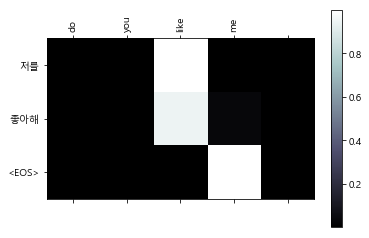

In [37]:
own_sentence = 'do you like me'
own_sentence = normalizeString(own_sentence)
print('Source: ', own_sentence)
output_words, attentions = evaluate(encoder, attn_decoder, own_sentence)
output_sentence = ' '.join(output_words)
print('Translated: ', output_sentence)
print('') 

show_attention(own_sentence, output_sentence, attentions.data)